# Training a neural network with an AMS based loss function #

### This notebook focuses on using a differentiable approximation of the approximate median significance metric as a loss function for training binary classification type neural networks in high energy particle physics. ###

#### Dataset preprocessing ####

Datasets are sourced from Kaggle's Higgs Boson Machine Learning Challenge from 2014. The files are as follows:
- train.csv
- test.csv
- random_submission.csv

For this project, the training.csv file is utilized for hyperparameter and training time optimization and fully used for training the final model. The test.csv file is used to create the submission predictions for evaluating the final model. The random_submission.csv file provides an example file format for submission.

Files are read through NumPy's read_csv() function and translated to NumPy dataframes. Missing values are fixed through mean imputation. Since the distributions of the features are approximately normal, no significant skewness is caused through mean imputation. Median imputation is also an option.

In order to create the AMS loss function, a differentiable approximation had to be used of the actual metric. However, this approximation, much like the actual metric, is extremely unstable with low weight values and can easily fall out of control and produce NaN values. In order to prevent this, the values are clamped (PyTorch must be imported before this cell is run)

These cells should be run for dataset preprocessing.

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("data/training/training.csv")
test_df = pd.read_csv("data/test/test.csv")

print(train_df.shape)
train_df.head()

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [3]:
train_df.replace(-999.0, pd.NA, inplace=True)
test_df.replace(-999.0, pd.NA, inplace=True)

train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

train_df.dropna(axis=1, thresh=int(0.9 * len(train_df)), inplace=True)
test_df.dropna(axis=1, thresh=int(0.9 * len(test_df)), inplace=True)

In [4]:
train_df["Label"] = train_df["Label"].str.strip().str.lower()
train_df["Label"] = train_df["Label"].map({'s': 1, 'b': 0})

feature_cols = [col for col in train_df.columns if col.startswith("DER_") or col.startswith("PRI_")]

X_test = test_df[feature_cols]

In [5]:
def safe_ams_loss(y_pred, y_true, weights, b_reg=10.0):
    s = torch.sum(weights * y_pred * (y_true == 1).float())
    b = torch.sum(weights * y_pred * (y_true == 0).float())
    
    radicand = 2 * ((s + b + b_reg) * torch.log(1 + s / (b + b_reg)) - s)
    
    # Clamp to prevent negative sqrt
    radicand = torch.clamp(radicand, min=0.0)
    ams = torch.sqrt(radicand)
    
    if torch.isnan(ams) or torch.isinf(ams):
        return torch.tensor(0.0, requires_grad=True)
    
    return -ams  # negative for minimization

#### Initial training and hyperparameter optimization with Optuna ####

Initial model training and hyperparameter optimization is done simultaneously using the Optuna library. The hyperparameters being tuned are:
- n_layers
- hidden_size
- dropout_rate
- lr
- batch_size

The dataset is split using stratified k-fold cross validation. For the initial training, k=3 for faster processing and quicker optimization of the hyperparameter optimization. Each trial is optimized to achieve a higher mean AMS score across the 3 folds.

At the end of the run, the best trial is given with its AMS score average and the optimal parameters.

These cells only need to be run in order to see the optimized hyperparameter values. Since Optuna is running with 50 trials, the cell will take some hours to finish running.

In [6]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Prepare data
X = train_df[feature_cols].values
y = train_df["Label"].values.reshape(-1, 1)
w = train_df["Weight"].values.reshape(-1, 1)

def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_size = trial.suggest_int("hidden_size", 64, 512, step=64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    epochs = 10  # keep small for tuning

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ams_scores = []
    auc_roc_scores = []

    for train_idx, val_idx in skf.split(X, y.ravel()):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        w_train, w_val = w[train_idx], w[val_idx]

        # Standardize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        w_train_tensor = torch.tensor(w_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        w_val_tensor = torch.tensor(w_val, dtype=torch.float32)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Build model
        layers = []
        input_size = X.shape[1]
        for _ in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, 1))
        layers.append(nn.Sigmoid())
        model = nn.Sequential(*layers)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train
        model.train()
        for epoch in range(epochs):
            for xb, yb, wb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = safe_ams_loss(preds, yb, wb)
                loss.backward()
                optimizer.step()

        # Evaluate AMS on validation set
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor)
        ams = -safe_ams_loss(val_preds, y_val_tensor, w_val_tensor).item()
        ams_scores.append(ams)

    return np.mean(ams_scores)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)

C:\Users\visha\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-21 17:05:52,906] A new study created in memory with name: no-name-7ddb822f-81e1-49db-84b6-faa5a0aa9f52
[I 2025-06-21 17:10:59,945] Trial 0 finished with value: 1.1425320704778035 and parameters: {'n_layers': 3, 'hidden_size': 448, 'dropout': 0.13610830410212912, 'lr': 0.00016383556380328184, 'batch_size': 256}. Best is trial 0 with value: 1.1425320704778035.
[I 2025-06-21 17:14:22,667] Trial 1 finished with value: 1.5846002499262493 and parameters: {'n_layers': 3, 'hidden_size': 128, 'dropout': 0.12221803893502133, 'lr': 0.0003297041778879724, 'batch_size': 128}. Best is trial 1 with value: 1.5846002499262493.
[I 2025-06-21 17:17:53,151] Trial 2 finished with value: 1.4588292837142944 and parameters: {'n_layers':

Best trial:
{'n_layers': 2, 'hidden_size': 448, 'dropout': 0.18657792297018724, 'lr': 0.0010795586890825545, 'batch_size': 256}


#### Final testing of model ####

The final testing of the model is done through stratified k-fold cross validation with k=3, using the optimized hyperparameters from Optuna. The number of folds was set to 3 in order to maintain a sufficiently large amount of data for model training, because the AMS metric fluctuates wildly at small amounts of data such as when k=5. Since 3 models are being trained, 3 metrics are calculated for each model and averaged at the end. The 3 metrics are:
- Area under the receiver operating characteristic curve (AUC-ROC)
- Accuracy
- Approximate median significance (AMS)

Furthermore, the graphs of loss vs. time(epochs) is graphed in order to check for overfitting. After several reruns, the optimal amount of time was determined to be 10 epochs.

These cells should be run for testing optimized hyperparameters, which have already been entered in. For testing of different hyperparameters, change the best_params dictionary to contain the different values.

In [6]:
y = train_df["Label"].values.reshape(-1,1)

best_params = {
    'n_layers': 2,
    'hidden_size': 448,
    'dropout': 0.18657792297018724,
    'lr': 0.0010795586890825545,
    'batch_size': 256
}

In [27]:
auc_scores = []
acc_scores = []
ams_scores = []


Fold 1/3
NaN values in predictions: 0
Epoch 1: Loss = -0.0691, Val AMS = 1.3741, AUC-ROC = 0.8439, Accuracy = 0.7782
NaN values in predictions: 0
Epoch 2: Loss = -0.0744, Val AMS = 1.5637, AUC-ROC = 0.8547, Accuracy = 0.7971
NaN values in predictions: 0
Epoch 3: Loss = -0.0761, Val AMS = 1.6908, AUC-ROC = 0.8591, Accuracy = 0.7881
NaN values in predictions: 0
Epoch 4: Loss = -0.0766, Val AMS = 1.5117, AUC-ROC = 0.8529, Accuracy = 0.7987
NaN values in predictions: 0
Epoch 5: Loss = -0.0774, Val AMS = 1.6190, AUC-ROC = 0.8589, Accuracy = 0.8074
NaN values in predictions: 0
Epoch 6: Loss = -0.0776, Val AMS = 1.6081, AUC-ROC = 0.8634, Accuracy = 0.8054
NaN values in predictions: 0
Epoch 7: Loss = -0.0781, Val AMS = 1.6584, AUC-ROC = 0.8506, Accuracy = 0.7995
NaN values in predictions: 0
Epoch 8: Loss = -0.0780, Val AMS = 1.6657, AUC-ROC = 0.8534, Accuracy = 0.8058
NaN values in predictions: 0
Epoch 9: Loss = -0.0781, Val AMS = 1.6595, AUC-ROC = 0.8549, Accuracy = 0.8052
NaN values in pred

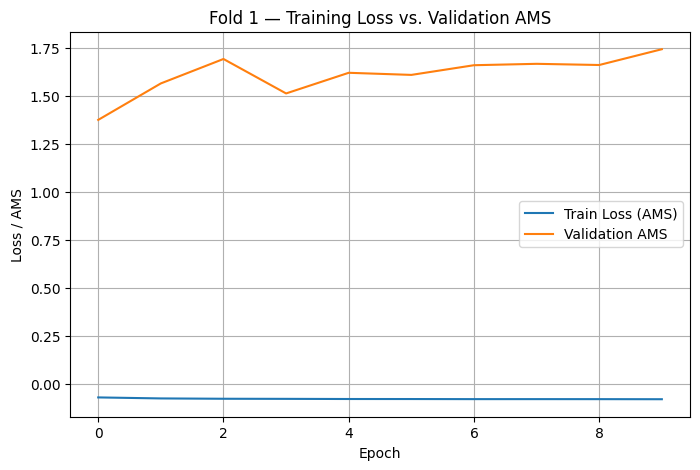


Fold 2/3
NaN values in predictions: 0
Epoch 1: Loss = -0.0674, Val AMS = 1.5029, AUC-ROC = 0.8492, Accuracy = 0.7919
NaN values in predictions: 0
Epoch 2: Loss = -0.0735, Val AMS = 1.5334, AUC-ROC = 0.8541, Accuracy = 0.7941
NaN values in predictions: 0
Epoch 3: Loss = -0.0754, Val AMS = 1.5871, AUC-ROC = 0.8622, Accuracy = 0.8059
NaN values in predictions: 0
Epoch 4: Loss = -0.0762, Val AMS = 1.6913, AUC-ROC = 0.8610, Accuracy = 0.8022
NaN values in predictions: 0
Epoch 5: Loss = -0.0772, Val AMS = 1.6589, AUC-ROC = 0.8672, Accuracy = 0.8113
NaN values in predictions: 0
Epoch 6: Loss = -0.0774, Val AMS = 1.6847, AUC-ROC = 0.8614, Accuracy = 0.8083
NaN values in predictions: 0
Epoch 7: Loss = -0.0776, Val AMS = 1.6262, AUC-ROC = 0.8588, Accuracy = 0.8068
NaN values in predictions: 0
Epoch 8: Loss = -0.0774, Val AMS = 1.6695, AUC-ROC = 0.8563, Accuracy = 0.8081
NaN values in predictions: 0
Epoch 9: Loss = -0.0782, Val AMS = 1.7152, AUC-ROC = 0.8565, Accuracy = 0.8109
NaN values in pred

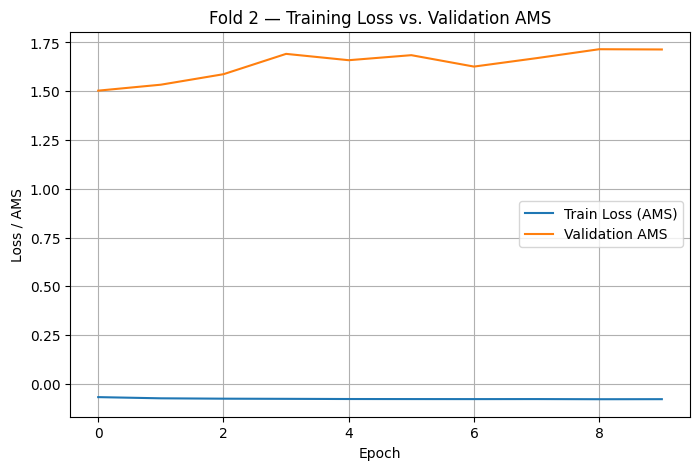


Fold 3/3
NaN values in predictions: 0
Epoch 1: Loss = -0.0681, Val AMS = 1.5803, AUC-ROC = 0.8496, Accuracy = 0.7878
NaN values in predictions: 0
Epoch 2: Loss = -0.0743, Val AMS = 1.6277, AUC-ROC = 0.8583, Accuracy = 0.7865
NaN values in predictions: 0
Epoch 3: Loss = -0.0757, Val AMS = 1.5570, AUC-ROC = 0.8576, Accuracy = 0.8020
NaN values in predictions: 0
Epoch 4: Loss = -0.0763, Val AMS = 1.5992, AUC-ROC = 0.8579, Accuracy = 0.8007
NaN values in predictions: 0
Epoch 5: Loss = -0.0769, Val AMS = 1.5541, AUC-ROC = 0.8563, Accuracy = 0.8050
NaN values in predictions: 0
Epoch 6: Loss = -0.0774, Val AMS = 1.6972, AUC-ROC = 0.8648, Accuracy = 0.8075
NaN values in predictions: 0
Epoch 7: Loss = -0.0779, Val AMS = 1.7024, AUC-ROC = 0.8525, Accuracy = 0.8000
NaN values in predictions: 0
Epoch 8: Loss = -0.0785, Val AMS = 1.6567, AUC-ROC = 0.8552, Accuracy = 0.8053
NaN values in predictions: 0
Epoch 9: Loss = -0.0784, Val AMS = 1.6791, AUC-ROC = 0.8583, Accuracy = 0.8089
NaN values in pred

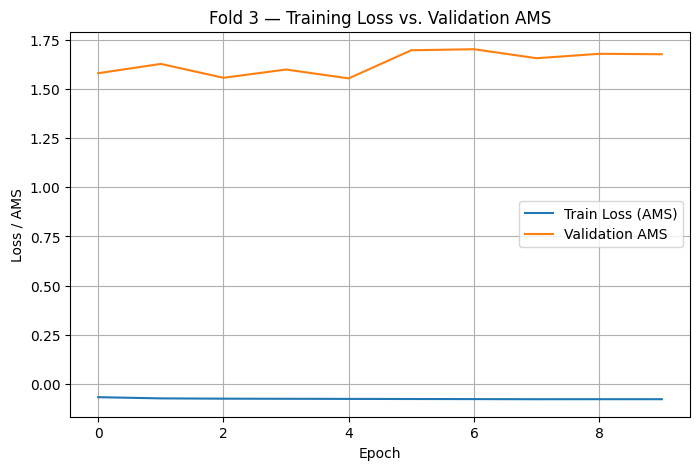

In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Data
X = train_df[feature_cols].values
y = train_df["Label"].values.reshape(-1, 1)
w = train_df["Weight"].values.reshape(-1, 1)

n_epochs = 10
k = 3

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.ravel())):
    print(f"\nFold {fold+1}/{k}")

    # Split and scale
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    w_train, w_val = w[train_idx], w[val_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    w_train_tensor = torch.tensor(w_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    w_val_tensor = torch.tensor(w_val, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

    # Model
    input_size = X.shape[1]
    layers = []
    for _ in range(best_params["n_layers"]):
        layers.append(nn.Linear(input_size, best_params["hidden_size"]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(best_params["dropout"]))
        input_size = best_params["hidden_size"]
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

    # Tracking
    train_losses = []
    current_fold_ams_vals = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for xb, yb, wb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = safe_ams_loss(preds, yb, wb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation AMS
        model.eval()
        with torch.no_grad():
            val_probs = model(X_val_tensor)
            val_probs_np = val_probs.detach().numpy().flatten()
            nan_mask = np.isnan(val_probs_np)

            num_nans = np.sum(nan_mask)
            print(f"NaN values in predictions: {num_nans}")

            if num_nans > 0:
                print("NaN detected in predicted probabilities")

            val_probs_clean = val_probs_np[~nan_mask]
            
            val_preds = (val_probs_clean > 0.5).astype(int)
            ams = -safe_ams_loss(val_probs, y_val_tensor, w_val_tensor).item()
    
         # AUC
        auc = roc_auc_score(y_val, val_probs_clean)
        
        # Accuracy
        acc = accuracy_score(y_val, val_preds)
    
        train_losses.append(epoch_loss / len(train_loader))
        current_fold_ams_vals.append(ams)
        
        ams_scores.append(ams)
        auc_scores.append(auc)
        acc_scores.append(acc)
        
        print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Val AMS = {ams:.4f}, AUC-ROC = {auc:.4f}, Accuracy = {acc:.4f}")

    # Plot for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss (AMS)")
    plt.plot(current_fold_ams_vals, label="Validation AMS")
    plt.title(f"Fold {fold+1} — Training Loss vs. Validation AMS")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / AMS")
    plt.legend()
    plt.grid(True)
    plt.show()


In [35]:
print(f"\nFinal 3-Fold Metrics:")
print(f"Average AUC: {np.mean(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average AMS: {np.mean(ams_scores):.4f}")


Final 3-Fold Metrics:
Average AUC: 0.8567
Average Accuracy: 0.8026
Average AMS: 1.6312


#### Final Submission Model ####

In these cells, a final model is trained on the entire training.csv dataset using the optimal hyperparameters from Optuna and also the optimal training time from the tests above.

During the training, loss is printed next to the corresponding epoch to check for any severe variations.

Finally, the model is used to create predictions on test.csv. These predictions are then submitted to Kaggle after creating a .csv file in the format provided in random_submission. The submission includes 3 columns:
- Event ID
- Rank Order (in terms of event significance)
- Label ('s' or 'b' for signal or background events)

The final submission to Kaggle yielded an AMS score of: 2.96330

In [37]:
# Prepare full training data
X_full = train_df[feature_cols].values
y_full = train_df["Label"].values.reshape(-1, 1)
w_full = train_df["Weight"].values.reshape(-1, 1)

# Standardize
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

# Convert to tensors
X_tensor = torch.tensor(X_full_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_full, dtype=torch.float32)
w_tensor = torch.tensor(w_full, dtype=torch.float32)

# DataLoader
batch_size = best_params['batch_size']
train_dataset = TensorDataset(X_tensor, y_tensor, w_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define model
input_size = X_tensor.shape[1]
layers = []
for _ in range(best_params["n_layers"]):
    layers.append(nn.Linear(input_size, best_params["hidden_size"]))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(best_params["dropout"]))
    input_size = best_params["hidden_size"]
layers.append(nn.Linear(input_size, 1))
layers.append(nn.Sigmoid())
final_model = nn.Sequential(*layers)

# Train the model
final_model.train()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
epochs = 10  # or increase if needed
for epoch in range(epochs):
    total_loss = 0
    for xb, yb, wb in train_loader:
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = safe_ams_loss(preds, yb, wb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: -0.0700
Epoch 2/10, Loss: -0.0762
Epoch 3/10, Loss: -0.0767
Epoch 4/10, Loss: -0.0774
Epoch 5/10, Loss: -0.0780
Epoch 6/10, Loss: -0.0785
Epoch 7/10, Loss: -0.0784
Epoch 8/10, Loss: -0.0792
Epoch 9/10, Loss: -0.0790
Epoch 10/10, Loss: -0.0794


In [38]:
X_test_scaled = scaler.transform(X_test.values)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [39]:
model.eval()
with torch.no_grad():
    test_probs = final_model(X_test_tensor).numpy().flatten()

In [40]:
test_df["prob"] = test_probs
test_df["RankOrder"] = test_df["prob"].rank(method='first', ascending=False).astype(int)
test_df["Class"] = np.where(test_df["prob"] > 0.5, 's', 'b')

submission_df = test_df[["EventId", "RankOrder", "Class"]]
submission_df.to_csv("submission_ams.csv", index=False)

#### Exporting Prediction for Significance Test ####

To compare this AMS-loss model to the standard BCE-loss model, we need a set of predictions that can be evaluated. Since the previously generated dataset for Kaggle cannot be evaluated locally, significance testing is not possible.

To bypass this, we will use stratified k-fold cross validation to allow for prediction evaluation. We will run this with 3 folds and then export the results in a .csv file for analysis in a different notebook.

In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Data
X = train_df[feature_cols].values
y = train_df["Label"].values.reshape(-1, 1)
w = train_df["Weight"].values.reshape(-1, 1)

# Save predictions here
all_preds = []
all_true = []
all_weights = []
all_fold_ids = []

# Stratified K-Fold
k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.ravel())):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    w_train, w_val = w[train_idx], w[val_idx]

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    w_train_tensor = torch.tensor(w_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

    # Model
    input_size = X_train_tensor.shape[1]
    layers = []
    for _ in range(best_params["n_layers"]):
        layers.append(nn.Linear(input_size, best_params["hidden_size"]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(best_params["dropout"]))
        input_size = best_params["hidden_size"]
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

    # Train
    model.train()
    for epoch in range(10):
        for xb, yb, wb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = safe_ams_loss(preds, yb, wb)
            loss.backward()
            optimizer.step()

    # Predict on validation set
    model.eval()
    with torch.no_grad():
        val_probs = model(X_val_tensor).numpy().flatten()
    
    all_preds.extend(val_probs)
    all_true.extend(y_val.flatten())
    all_weights.extend(w_val.flatten())
    all_fold_ids.extend([fold] * len(y_val))

# Save to CSV
ams_preds_df = pd.DataFrame({
    "fold": all_fold_ids,
    "true_label": all_true,
    "weight": all_weights,
    "pred_prob": all_preds
})

ams_preds_df.to_csv("ams_preds.csv", index=False)